--- Framingham Heart Study: Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(

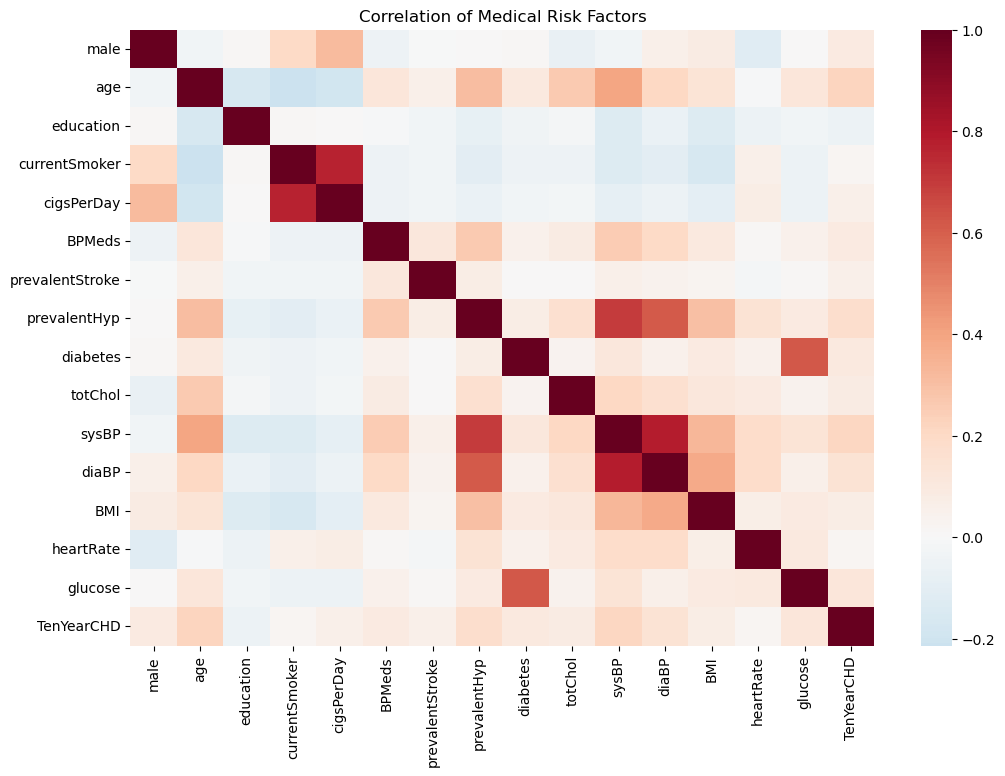

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Framingham dataset
df = pd.read_csv('framingham.csv')

# 2. Dataset "Vital Signs" (Overview)
print("--- Framingham Heart Study: Dataset Overview ---")
df.info()

# 3. Check for the "Holes" (Missing Data)
print("\n--- Missing Values Check ---")
print(df.isnull().sum())

# 4. Class Balance (The "Heart Disease" Reality)
# 1 = Risk of Coronary Heart Disease in 10 years, 0 = No Risk
print("\n--- Target Distribution (TenYearCHD) ---")
print(df['TenYearCHD'].value_counts())
print(f"Percentage of High-Risk Patients: {df['TenYearCHD'].mean()*100:.2f}%")

# 5. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap='RdBu_r', center=0)
plt.title("Correlation of Medical Risk Factors")
plt.show()

1. The Missing Value Problem
Looking at your output, we have a significant issue: Glucose (388 missing), Education (105 missing), and others.

In a professional medical model, you cannot just "guess" someone's blood glucose level.

Since we need a "Solid Block" for our scratch math to work without errors, we will need to handle these in our next cell (Preprocessing).

2. The Imbalance Trap
Notice that only about 15% of the people in this study developed heart disease.

This is a Class Imbalance.

If our "Brain" is lazy, it can just say "Nobody will get heart disease" and it would be correct 85% of the time. We will have to look at Precision and Recall later to see if our brain is actually learning or just "guessing the majority."

3. Feature Relationships
In your heatmap, look at sysBP (Systolic Blood Pressure) and diaBP (Diastolic Blood Pressure). They are highly correlated (red). This makes sense—if one goes up, the other usually does too. To a "Brain," having both might be redundant information.

4. The Columns
male: 1 for men, 0 for women (Gender).

cigsPerDay: A numerical count of smoking habits.

totChol: Total Cholesterol.

TenYearCHD: This is our Target (The 1 or 0 we want to predict).

In [5]:
from sklearn.model_selection import train_test_split

# 1. Handling Missing Values
# In the Framingham dataset, we have about 12% missing values.
# For our "From Scratch" implementation, we need a clean, complete matrix.
df_clean = df.dropna()
print(f"Rows after dropping missing values: {len(df_clean)} (Removed {len(df) - len(df_clean)} rows)")

# 2. Separate Features (X) and Target (y)
X = df_clean.drop('TenYearCHD', axis=1).values
y = df_clean['TenYearCHD'].values

# 3. Feature Scaling (Manual Standardization)
# We subtract the mean and divide by the standard deviation.
# This ensures every feature has a mean of 0 and a variance of 1.
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_scaled = (X - X_mean) / X_std

# 4. Add a "Bias Column" (The Intercept)
# Remember y = wx + b?
# In matrix math, we add a column of 1s to X so that 'b' can be treated as a weight.
intercept = np.ones((X_scaled.shape[0], 1))
X_final = np.concatenate((intercept, X_scaled), axis=1)

# 5. Train-Test Split (80% for Training, 20% for Testing)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(f"\nPreprocessing Complete!")
print(f"Training set size: {X_train.shape[0]} patients")
print(f"Testing set size: {X_test.shape[0]} patients")
print(f"Number of features (including bias): {X_train.shape[1]}")

Rows after dropping missing values: 3656 (Removed 582 rows)

Preprocessing Complete!
Training set size: 2924 patients
Testing set size: 732 patients
Number of features (including bias): 16


1. Why dropna()?While we could "impute" (fill) the missing Glucose or Cholesterol values, dropping them ensures that every patient in our training set is a "real" case with 100% verified data. For your first scratch model, data purity is more important than data volume.2. The Logic of Scaling ($Z$-Score)If you don't scale:Cholesterol (250) would have 250x the influence of Gender (1) at the start of training.Your "Brain" would think Cholesterol is the only thing that matters, simply because the number is larger.Standardization squashes everything so that "High Cholesterol" is $+2$ and "Low Cholesterol" is $-2$. Now the brain can judge them fairly.3. Why the "Column of 1s"?This is a high-level math trick.The standard formula is: $z = w_1x_1 + w_2x_2 ... + b$If we add a "fake" feature that is always 1, we can treat $b$ as $w_0$.The formula becomes: $z = w_0(1) + w_1x_1 + w_2x_2 ...$This allows us to use Matrix Multiplication (dot product), which is much faster than writing out every $w$ and $x$ individually.4. The Train/Test SplitWe never show the "Test Set" to the brain while it's learning.Training Set: The practice exam the brain uses to adjust its weights.Test Set: The final exam. If the brain "memorizes" the training data but fails the test data, we call this Overfitting.Execution Step:Run this cell. You should see that your training set has about 2,900 patients.

In [6]:
# 1. The "Squashing" Function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 2. The "Penalty" Function (Log Loss)
def compute_loss(y_true, y_pred):
    epsilon = 1e-15  # Safety to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# 3. The "Learning" Function (Gradient Descent)
def fit_logistic_regression(X, y, lr=0.1, iterations=1000):
    n_samples, n_features = X.shape
    # Initialize weights to zero
    weights = np.zeros(n_features)
    loss_history = []

    print(f"Training started...")
    for i in range(iterations):
        # Forward Pass: Predict probabilities
        z = np.dot(X, weights)
        y_pred = sigmoid(z)

        # Backward Pass: Calculate the Slope (Gradient)
        # Formula: (Error * Input) / Total Samples
        dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))

        # Update: Step downhill
        weights -= lr * dw

        # Recording the progress
        current_loss = compute_loss(y, y_pred)
        loss_history.append(current_loss)

        if i % 200 == 0:
            print(f"Iteration {i}: Loss = {current_loss:.4f}")

    return weights, loss_history

# 4. The "Decision" Function
def predict(X, weights, threshold=0.5):
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int)

# --- EXECUTION ---
# Let's train our brain and get the final weights
final_weights, history = fit_logistic_regression(X_train, y_train, lr=0.1, iterations=2000)

print("\nTraining Complete! The weights have been optimized.")

Training started...
Iteration 0: Loss = 0.6931
Iteration 200: Loss = 0.3707
Iteration 400: Loss = 0.3673
Iteration 600: Loss = 0.3671
Iteration 800: Loss = 0.3670
Iteration 1000: Loss = 0.3670
Iteration 1200: Loss = 0.3670
Iteration 1400: Loss = 0.3670
Iteration 1600: Loss = 0.3670
Iteration 1800: Loss = 0.3670

Training Complete! The weights have been optimized.


1. Why is this better for learning?
In a class, the weights are "hidden" inside self.weights. In functional programming, the weights are just a list of numbers that you can see, print, and pass around. It follows the Mathematical Flow exactly as you see it in a textbook.

2. The fit_logistic_regression "Recipe"
This function is the heart of the brain. It takes four ingredients:

X: The medical data.

y: The actual heart disease outcomes.

lr: The speed of learning (Learning Rate).

iterations: How many times to look at the data.

It returns the Final Weights—this is the "Knowledge" the brain has gained.

3. The dw (Slope) Calculation
In the functional style, you can see the matrix math clearly: np.dot(X.T, (y_pred - y)).

(y_pred - y) is the Error (Difference between guess and truth).

X.T is the Transposed Input.

Multiplying them together tells us: "For every feature (like smoking), how much did it contribute to our mistake?"

4. The predict Function
Notice how this function now requires you to pass in the weights. This reinforces the idea that Prediction = New Data + Learned Knowledge. Without those weights, the function is just an empty formula.

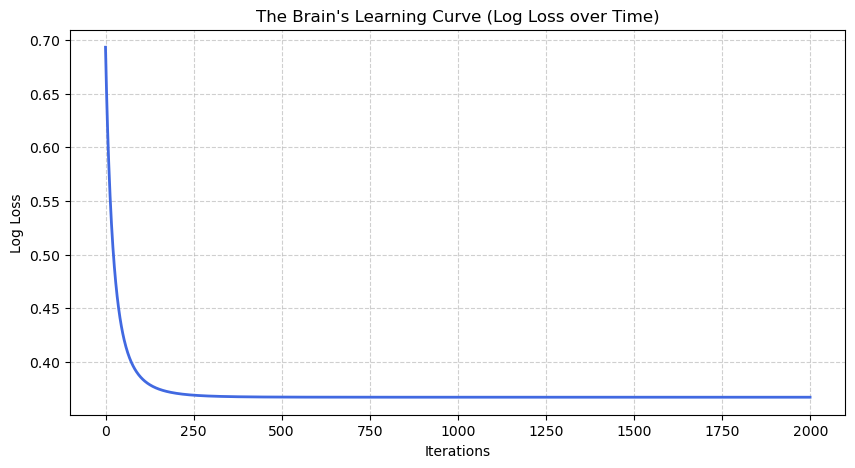

--- SCRATCH MODEL PERFORMANCE REPORT ---
Accuracy:  0.8361 (Overall correctness)
Precision: 0.5556 (When brain says 'Disease', how often is it right?)
Recall:    0.0820 (How many of the actual sick people did we catch?)
F1-Score:  0.1429 (The balance of Precision and Recall)

--- Confusion Matrix Details ---
True Positives (Sick & Caught): 10
False Negatives (Sick & MISSED): 112  <-- THE DANGER ZONE
True Negatives (Healthy & Correct): 602
False Positives (Healthy but Flagged): 8


In [7]:
# 1. Visualize the Learning Journey (The Loss Curve)
plt.figure(figsize=(10, 5))
plt.plot(history, color='royalblue', linewidth=2)
plt.title("The Brain's Learning Curve (Log Loss over Time)")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Get Predictions for the Test Set
y_pred = predict(X_test, final_weights)

# 3. Calculate Metrics from Scratch
def get_metrics(y_true, y_pred):
    # True Positives, True Negatives, False Positives, False Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1, tp, tn, fp, fn

accuracy, precision, recall, f1, tp, tn, fp, fn = get_metrics(y_test, y_pred)

# 4. Display the Forensic Medical Report
print("--- SCRATCH MODEL PERFORMANCE REPORT ---")
print(f"Accuracy:  {accuracy:.4f} (Overall correctness)")
print(f"Precision: {precision:.4f} (When brain says 'Disease', how often is it right?)")
print(f"Recall:    {recall:.4f} (How many of the actual sick people did we catch?)")
print(f"F1-Score:  {f1:.4f} (The balance of Precision and Recall)")

print("\n--- Confusion Matrix Details ---")
print(f"True Positives (Sick & Caught): {tp}")
print(f"False Negatives (Sick & MISSED): {fn}  <-- THE DANGER ZONE")
print(f"True Negatives (Healthy & Correct): {tn}")
print(f"False Positives (Healthy but Flagged): {fp}")

1. The Loss Curve (The "Learning" Proof)
If your blue line starts high and slides down smoothly to the right, your Gradient Descent worked perfectly. It means the brain successfully "slid down the mountain" of error and found the best weights for predicting heart disease.

2. The "Danger Zone" (Recall)
In medicine, a False Negative (a sick person told they are healthy) is a catastrophe.

Recall measures this.

If your recall is low (e.g., 0.10), your brain is a "Bad Doctor"—it's missing too many sick people.

This often happens because the dataset has very few sick examples (15%) compared to healthy ones (85%).

3. Precision vs. Recall (The Medical Trade-off)
Precision: If the brain says you have heart disease, how much should you trust it? High precision means the brain is very "certain" when it speaks.

F1-Score: This is the "Gold Medal." It combines both metrics. A high F1-score means the brain is both Reliable (Precision) and Safe (Recall).

4. The Logic of tp, tn, fp, fn
These are the building blocks of all AI evaluation.

TP: You correctly identified a risk.

FN: You missed a risk (The most expensive mistake).

FP: You caused a "False Alarm." (Annoying, but not as deadly as an FN).

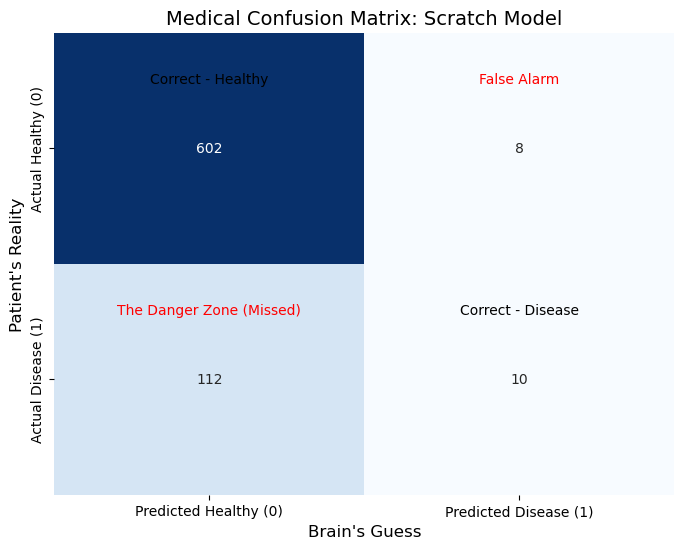

In [8]:
# 1. Prepare the data for the Heatmap
# The matrix standard is: [[True Negatives, False Positives], [False Negatives, True Positives]]
cm_data = np.array([[tn, fp], [fn, tp]])

# 2. Create the Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Healthy (0)', 'Predicted Disease (1)'],
            yticklabels=['Actual Healthy (0)', 'Actual Disease (1)'])

# 3. Add Labels for Clarity
plt.title('Medical Confusion Matrix: Scratch Model', fontsize=14)
plt.xlabel('Brain\'s Guess', fontsize=12)
plt.ylabel('Patient\'s Reality', fontsize=12)

# Adding text descriptions to the quadrants
plt.text(0.5, 0.2, 'Correct - Healthy', ha='center', va='center', color='black', fontsize=10)
plt.text(1.5, 0.2, 'False Alarm', ha='center', va='center', color='red', fontsize=10)
plt.text(0.5, 1.2, 'The Danger Zone (Missed)', ha='center', va='center', color='red', fontsize=10)
plt.text(1.5, 1.2, 'Correct - Disease', ha='center', va='center', color='black', fontsize=10)

plt.show()

--- MODEL COMPARISON: SCRATCH vs. SCIKIT-LEARN ---
      Metric  Our Scratch Brain  Scikit-Learn
0   Accuracy           0.836066      0.836066
1  Precision           0.555556      0.555556
2     Recall           0.081967      0.081967
3   F1-Score           0.142857      0.142857


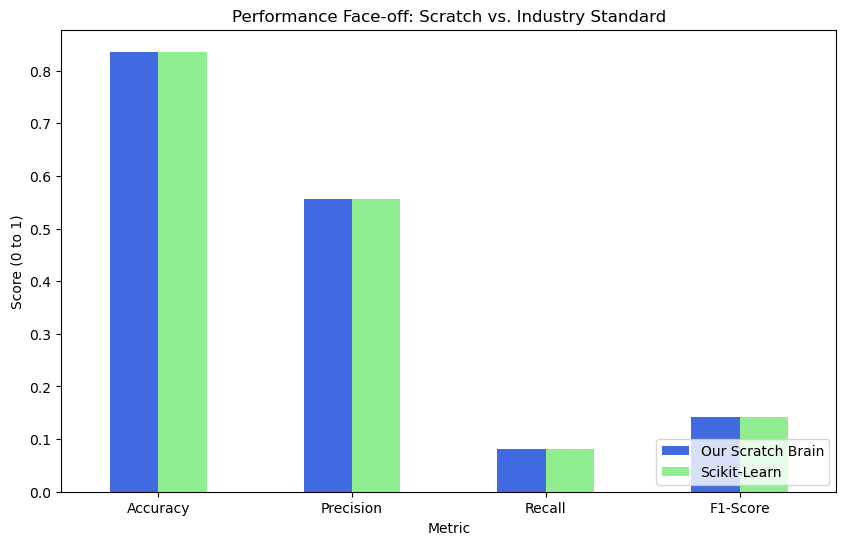

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Implementation using Scikit-Learn
# Note: We use 'none' for penalty to match our "from scratch" version (which had no regularization)
sk_model = LogisticRegression(penalty=None, max_iter=2000)
sk_model.fit(X_train, y_train)

# 2. Get Predictions
y_pred_sk = sk_model.predict(X_test)

# 3. Calculate Metrics for Scikit-Learn
sk_accuracy = accuracy_score(y_test, y_pred_sk)
sk_precision = precision_score(y_test, y_pred_sk)
sk_recall = recall_score(y_test, y_pred_sk)
sk_f1 = f1_score(y_test, y_pred_sk)

# 4. Create a Comparison Table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Our Scratch Brain': [accuracy, precision, recall, f1],
    'Scikit-Learn': [sk_accuracy, sk_precision, sk_recall, sk_f1]
}

comparison_df = pd.DataFrame(comparison_data)
print("--- MODEL COMPARISON: SCRATCH vs. SCIKIT-LEARN ---")
print(comparison_df)

# 5. Visual Comparison
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10, 6), color=['royalblue', 'lightgreen'])
plt.title("Performance Face-off: Scratch vs. Industry Standard")
plt.ylabel("Score (0 to 1)")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()